In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.0 igraph==0.11.5 pynndescent==0.5.12


In [2]:
nr = sc.read_h5ad('./h5ad/filter/V1_NR_L23_filter.h5ad')
dr = sc.read_h5ad('./h5ad/filter/V1_DR_L23_filter.h5ad')

In [3]:
import anndata 
from scipy.stats import zscore
from scipy import sparse 
import itertools
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from umap import UMAP
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

hvg_nr = nr[:, nr.var.highly_variable]
hvg_dr = dr[:, dr.var.highly_variable]

In [5]:
hvg_dr

View of AnnData object with n_obs × n_vars = 3166 × 3197
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Class', 'preclass', 'cluster', 'Class_new', 'Subclass', 'Sample', 'Type', 'Subtype', 'Cell_annotation', 'X_harmony_1', 'X_harmony_2'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_D1', 'highly_variable-V1_D1', 'means-V1_D1', 'dispersions-V1_D1', 'dispersions_norm-V1_D1', 'n_cells-V1_D2', 'highly_variable-V1_D2', 'means-V1_D2', 'dispersions-V1_D2', 'dispersions_norm-V1_D2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Class_colors', 'Sample_colors', 'Subclass_colors', 'Subtype_colors', 'Type_colors', 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'preclass_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
hvg_nr

View of AnnData object with n_obs × n_vars = 3376 × 2584
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Class', 'preclass', 'cluster', 'Subclass', 'Sample', 'Type', 'Subtype', 'Cell_annotation'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Class_colors', 'Sample_colors', 'Subclass_colors', 'Subtype_colors', 'Type_colors', 'cluster_colors', 'hvg', 'leiden_res_0.80', 'leiden_res_0.80_colors', 'leiden_res_1.00', 'leiden_res_1.00_colors', 'leiden_res_1.20', 'leiden_res_1.20_colors', 'neighbors', 'pca', 'preclass_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

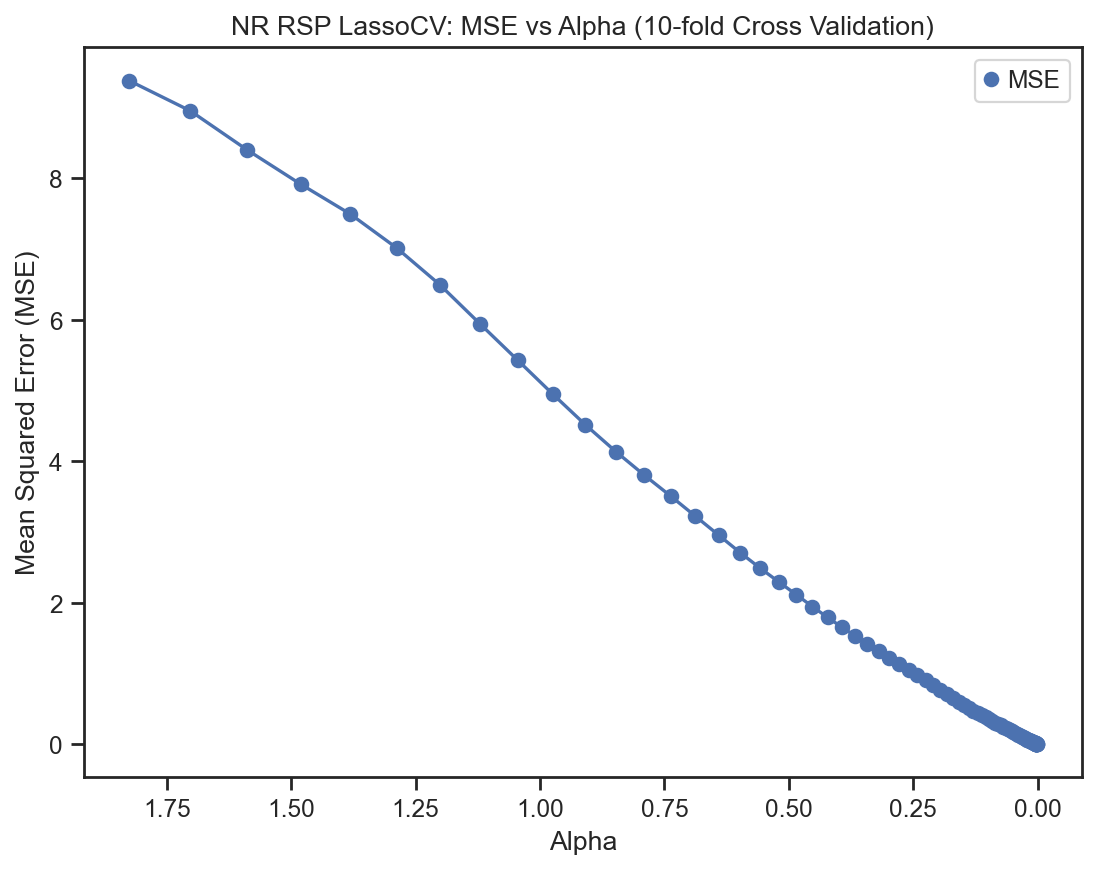

In [5]:
np.random.seed(0)
pca_nr = PCA(n_components=50)
hvg_nr_exp = np.array(hvg_nr.X.todense())
pcs_nr = pca_nr.fit_transform(hvg_nr_exp)
genes_sel_nr = hvg_nr.var.index.values
pc1_nr = pca_nr.components_[0]
pc1_idx_nr = np.argsort(np.abs(pc1_nr))[::-1]
genes_sel_nr[pc1_idx_nr]
nr_pca_gene = pd.DataFrame()
nr_pca_gene['PC1'] = genes_sel_nr[pc1_idx_nr]
nr_pca_gene['rank'] = range(nr_pca_gene.shape[0])

from sklearn.linear_model import LassoCV
sns.set_theme(style="ticks")
scaler = StandardScaler()
hvg_nr_exp_df= pd.DataFrame(hvg_nr_exp,index=hvg_nr.obs.index,columns= hvg_nr.var.index)
X_scaled_nr = scaler.fit_transform(hvg_nr_exp)

# Take the first principal component as the target variable
y_pca1_nr = pcs_nr[:, 0]  # use the first PC

# Define the LassoCV model and conduct a 10-fold cross-validatio
lasso_cv = LassoCV(cv=10, random_state=42)

# training model
lasso_cv.fit(X_scaled_nr, y_pca1_nr)

mse_mean = np.mean(lasso_cv.mse_path_, axis=1)
alphas = lasso_cv.alphas_

plt.figure(figsize=(8, 6))
plt.plot(alphas, mse_mean, marker='o', linestyle='-', color='b', label='MSE')
plt.gca().invert_xaxis()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('NR RSP LassoCV: MSE vs Alpha (10-fold Cross Validation)')
plt.legend()
plt.show()

In [5]:
lasso_cv.alpha_

0.0018259717028287915

In [6]:
# Lasso model (L1 regularization）
lasso = Lasso(alpha=0.0018259717028287915)  # alpha controls the regularization intensity and makes appropriate adjustments
lasso.fit(X_scaled_nr, y_pca1_nr)

# Step 4: Check the coefficient of each gene (i.e., its contribution to the PCA variation)
lasso_coefficients_nr = lasso.coef_
#Take the absolute value of the lasso coefficient
lasso_coefficients_abs_nr = np.abs(lasso_coefficients_nr)
# Save the gene names and the corresponding Lasso coefficients to the DataFrame
gene_contributions_nr = pd.DataFrame({
    'Gene': hvg_nr_exp_df.columns,
    'Lasso Coefficient': lasso_coefficients_nr,
    'Lasso Coefficient abs': lasso_coefficients_abs_nr
})
# Check the genes that have made a significant contribution to the first principal component
gene_contributions_abs_nr = gene_contributions_nr.sort_values(by='Lasso Coefficient abs', ascending=False)

In [7]:
gene_contributions_abs_nr

,Gene,Lasso Coefficient,Lasso Coefficient abs
205,Etl4,0.197230,0.197230
2193,Epha6,-0.179037,0.179037
396,Egfem1,-0.179016,0.179016
2480,Sorcs3,0.176614,0.176614
1258,Cntn5,-0.164911,0.164911
...,...,...,...
1433,4930547M16Rik,0.000000,0.000000
591,Gm44037,-0.000000,0.000000
1431,Ccn6,-0.000000,0.000000
592,Fyb2,-0.000000,0.000000


In [8]:
gene_contributions_nr

,Gene,Lasso Coefficient,Lasso Coefficient abs
0,Gm1992,-0.026493,0.026493
1,Rgs20,0.014965,0.014965
2,Rrs1,0.000000,0.000000
3,1700034P13Rik,-0.000000,0.000000
4,Sgk3,-0.012335,0.012335
...,...,...,...
2579,mt-Nd3,0.000000,0.000000
2580,mt-Nd4,0.001169,0.001169
2581,mt-Nd5,-0.000000,0.000000
2582,mt-Cytb,0.000000,0.000000


In [9]:
hvg_nr

View of AnnData object with n_obs × n_vars = 3376 × 2584
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Class', 'preclass', 'cluster', 'Subclass', 'Sample', 'Type', 'Subtype', 'Cell_annotation'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Class_colors', 'Sample_colors', 'Subclass_colors', 'Subtype_colors', 'Type_colors', 'cluster_colors', 'hvg', 'leiden_res_0.80', 'leiden_res_0.80_colors', 'leiden_res_1.00', 'leiden_res_1.00_colors', 'leiden_res_1.20', 'leiden_res_1.20_colors', 'neighbors', 'pca', 'preclass_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

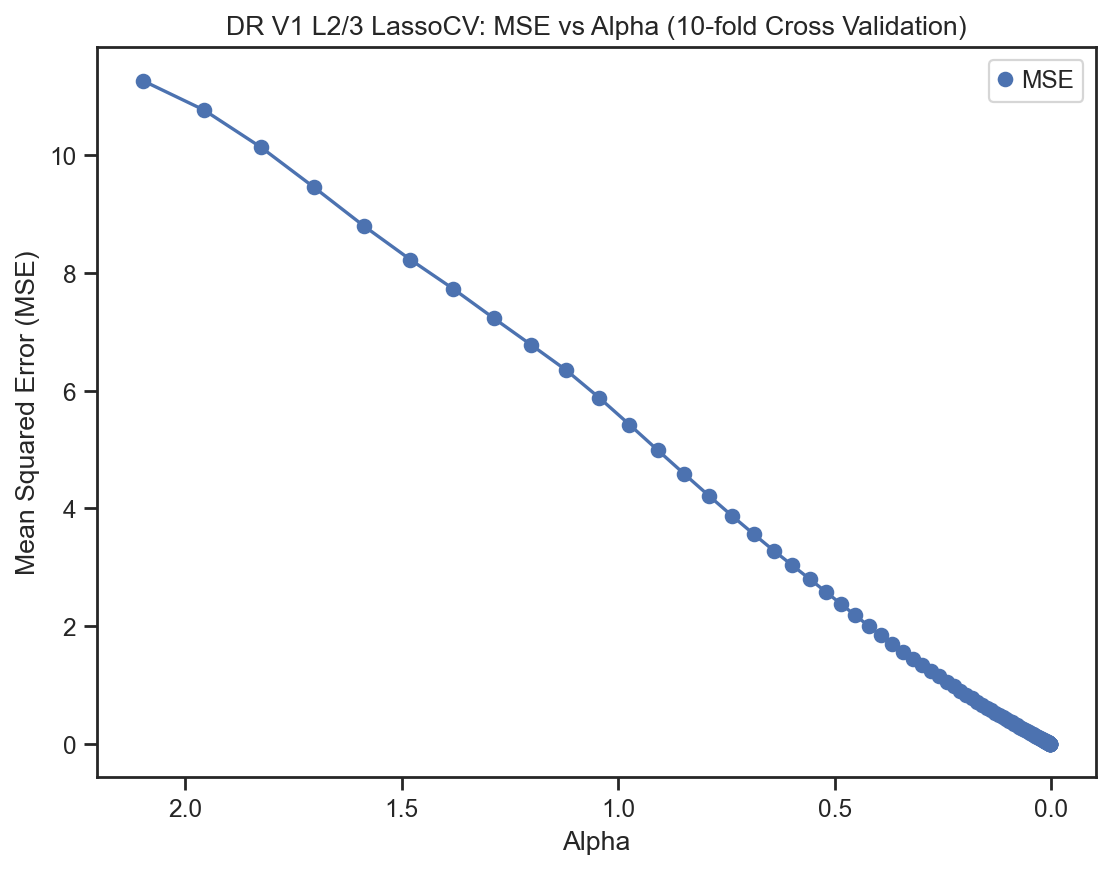

In [10]:
np.random.seed(0)
pca_dr = PCA(n_components=50)
hvg_dr_exp = np.array(hvg_dr.X.todense())
pcs_dr = pca_dr.fit_transform(hvg_dr_exp)
genes_sel_dr = hvg_dr.var.index.values
pc1_dr = pca_dr.components_[0]
pc1_idx_dr = np.argsort(np.abs(pc1_dr))[::-1]
genes_sel_dr[pc1_idx_dr]

dr_pca_gene = pd.DataFrame()
dr_pca_gene['PC1'] = genes_sel_dr[pc1_idx_dr]

dr_pca_gene['rank'] = range(dr_pca_gene.shape[0])

scaler = StandardScaler()
hvg_dr_exp_df= pd.DataFrame(hvg_dr_exp,index=hvg_dr.obs.index,columns= hvg_dr.var.index)
X_scaled_dr = scaler.fit_transform(hvg_dr_exp)
y_pca1_dr = pcs_dr[:, 0]  
lasso_cv = LassoCV(cv=10, random_state=42)
lasso_cv.fit(X_scaled_dr, y_pca1_dr)

mse_mean = np.mean(lasso_cv.mse_path_, axis=1)
alphas = lasso_cv.alphas_

plt.figure(figsize=(8, 6))
plt.plot(alphas, mse_mean, marker='o', linestyle='-', color='b', label='MSE')
plt.gca().invert_xaxis()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('DR V1 L2/3 LassoCV: MSE vs Alpha (10-fold Cross Validation)')
plt.legend()
#plt.grid(True)
plt.show()

In [11]:
lasso_cv.alpha_

0.002098636205484049

In [11]:

lasso = Lasso(alpha=0.002098636205484049)
lasso.fit(X_scaled_dr, y_pca1_dr)

lasso_coefficients_dr = lasso.coef_

lasso_coefficients_abs_dr = np.abs(lasso_coefficients_dr)

gene_contributions_dr = pd.DataFrame({
    'Gene': hvg_dr_exp_df.columns,
    'Lasso Coefficient': lasso_coefficients_dr,
    'Lasso Coefficient abs': lasso_coefficients_abs_dr
})

gene_contributions_abs_dr = gene_contributions_dr.sort_values(by='Lasso Coefficient abs', ascending=False)

In [12]:
gene_contributions_abs_dr

,Gene,Lasso Coefficient,Lasso Coefficient abs
2708,Epha6,0.190205,0.190205
2710,Robo1,0.158480,0.158480
1615,Cntn5,0.156916,0.156916
1591,Cdh13,0.145950,0.145950
2379,Homer1,-0.131020,0.131020
...,...,...,...
453,Zfp973,-0.000000,0.000000
454,Sycp2,0.000000,0.000000
456,Ss18l1,-0.000000,0.000000
1582,Gm45904,-0.000000,0.000000


In [15]:
gene_contributions_abs_nr

,Gene,Lasso Coefficient,Lasso Coefficient abs
205,Etl4,0.197230,0.197230
2193,Epha6,-0.179037,0.179037
396,Egfem1,-0.179016,0.179016
2480,Sorcs3,0.176614,0.176614
1258,Cntn5,-0.164911,0.164911
...,...,...,...
1433,4930547M16Rik,0.000000,0.000000
591,Gm44037,-0.000000,0.000000
1431,Ccn6,-0.000000,0.000000
592,Fyb2,-0.000000,0.000000


In [18]:
merged_df = pd.merge(gene_contributions_abs_nr, gene_contributions_abs_dr, on='Gene', how='outer', suffixes=(' NR', ' DR')).fillna(0)


In [19]:
merged_df 

,Gene,Lasso Coefficient NR,Lasso Coefficient abs NR,Lasso Coefficient DR,Lasso Coefficient abs DR
0,0610009B22Rik,0.000000,0.000000,0.000000,0.000000
1,0610009L18Rik,0.000000,0.000000,0.000000,0.000000
2,0610012G03Rik,0.000000,0.000000,-0.000000,0.000000
3,0610030E20Rik,0.000000,0.000000,-0.000000,0.000000
4,0610040F04Rik,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
4788,mt-Nd1,-0.000000,0.000000,0.000000,0.000000
4789,mt-Nd2,0.001774,0.001774,0.000825,0.000825
4790,mt-Nd3,0.000000,0.000000,0.000000,0.000000
4791,mt-Nd4,0.001169,0.001169,0.000000,0.000000


In [13]:
# 假设 gene_names 是与基因表达矩阵列对应的基因名称列表
gene_names_nr = np.array(gene_contributions_nr['Gene']) 

# 按贡献率排序
sorted_contribution_nr = np.sort(lasso_coefficients_abs_nr)[::-1]

# 计算累计贡献率
cumulative_contribution_nr = np.cumsum(sorted_contribution_nr)

# 计算总贡献
total_contribution_nr = cumulative_contribution_nr[-1]

# 按贡献率排序，获取贡献最大的基因索引
sorted_idx_nr = np.argsort(np.abs(lasso_coefficients_nr))[::-1]

In [25]:
cumulative_contribution_nr

array([ 0.19722964,  0.3762666 ,  0.55528307, ..., 12.776592  ,
       12.776592  , 12.776592  ], dtype=float32)

In [18]:
gene_names_nr.shape

(2584,)

In [14]:
dr_pca_gene = pd.DataFrame()
dr_pca_gene['Gene'] = genes_sel_dr[pc1_idx_dr]
dr_pca_gene['rank'] = range(dr_pca_gene.shape[0])

In [39]:
dr_pca_gene

,Gene,rank
0,Epha6,0
1,Cdh13,1
2,Cntn5,2
3,Robo1,3
4,Astn2,4
...,...,...
3192,Cnmd,3192
3193,Cst6,3193
3194,Runx1,3194
3195,Gm4013,3195


In [37]:
gene_contributions_abs_dr

,Gene,Lasso Coefficient,Lasso Coefficient abs
2708,Epha6,0.190205,0.190205
2710,Robo1,0.158480,0.158480
1615,Cntn5,0.156916,0.156916
1591,Cdh13,0.145950,0.145950
2379,Homer1,-0.131020,0.131020
...,...,...,...
453,Zfp973,-0.000000,0.000000
454,Sycp2,0.000000,0.000000
456,Ss18l1,-0.000000,0.000000
1582,Gm45904,-0.000000,0.000000


In [15]:
dr_merge = pd.merge(dr_pca_gene, gene_contributions_abs_dr, on='Gene', how='outer')

In [16]:
dr_merge

,Gene,rank,Lasso Coefficient,Lasso Coefficient abs
0,0610009B22Rik,2180,0.000000,0.000000
1,0610009L18Rik,2505,0.000000,0.000000
2,0610012G03Rik,1640,-0.000000,0.000000
3,0610030E20Rik,2788,-0.000000,0.000000
4,0610040F04Rik,2257,0.000000,0.000000
...,...,...,...,...
3192,mt-Co3,1454,0.002823,0.002823
3193,mt-Cytb,2543,0.000000,0.000000
3194,mt-Nd1,1541,0.000000,0.000000
3195,mt-Nd2,849,0.000825,0.000825


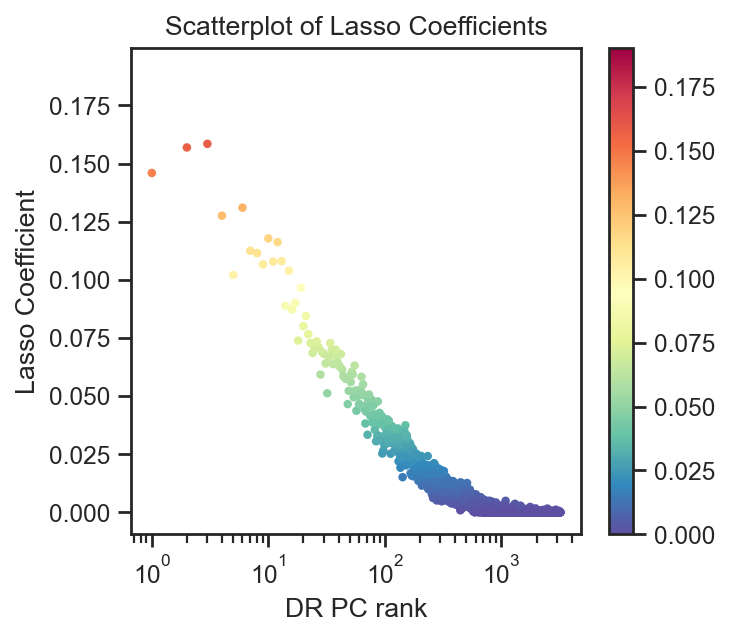

In [48]:
fig, ax = plt.subplots(figsize=(4.5, 4))

scatter = ax.scatter(x=dr_merge["rank"], 
                     y=dr_merge["Lasso Coefficient abs"], 
                     c=dr_merge["Lasso Coefficient abs"],
                     cmap='Spectral_r', s=8)

ax.set_xscale('log')

ax.set_title('Scatterplot of Lasso Coefficients')
ax.set_xlabel('DR PC rank')
ax.set_ylabel('Lasso Coefficient')

plt.colorbar(scatter, ax=ax)

plt.savefig('DR_PCrank_Lasso_Coefficients.pdf')

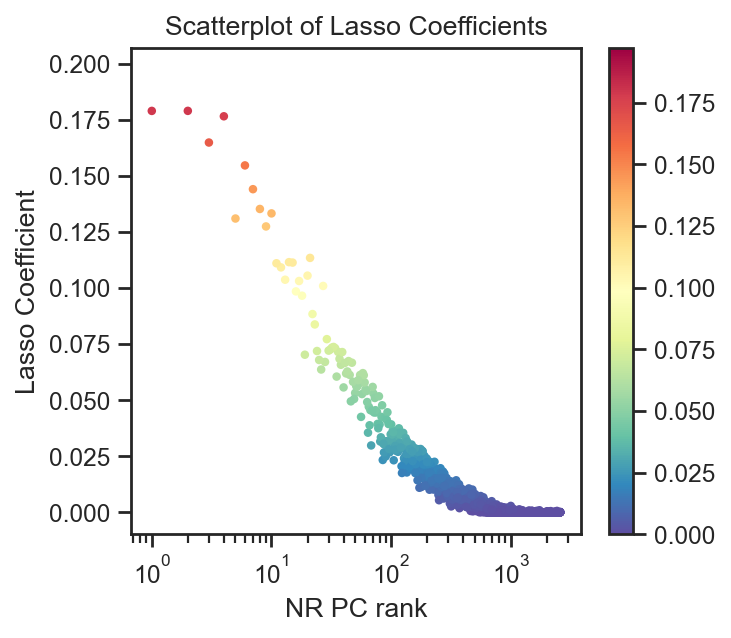

In [47]:
nr_pca_gene = pd.DataFrame()
nr_pca_gene['Gene'] = genes_sel_nr[pc1_idx_nr]
nr_pca_gene['rank'] = range(nr_pca_gene.shape[0])
nr_merge = pd.merge(nr_pca_gene, gene_contributions_abs_nr, on='Gene', how='outer')
fig, ax = plt.subplots(figsize=(4.5, 4))

scatter = ax.scatter(x=nr_merge["rank"], 
                     y=nr_merge["Lasso Coefficient abs"], 
                     c=nr_merge["Lasso Coefficient abs"],
                     cmap='Spectral_r', s=8)

ax.set_xscale('log')

ax.set_title('Scatterplot of Lasso Coefficients')
ax.set_xlabel('NR PC rank')
ax.set_ylabel('Lasso Coefficient')

plt.colorbar(scatter, ax=ax)

plt.savefig('NR_PCrank_Lasso_Coefficients.pdf')

In [19]:
num_genes = np.argmax(cumulative_contribution_nr >= 1 * total_contribution_nr) + 1
genes_idx_nr = sorted_idx_nr[:num_genes]
genes_nr = gene_names_nr[genes_idx_nr]

In [51]:
genes_nr.shape

(884,)

        Gene  Lasso Coefficient  Lasso Coefficient abs
2708   Epha6           0.190205               0.190205
2710   Robo1           0.158480               0.158480
1615   Cntn5           0.156916               0.156916
1591   Cdh13           0.145950               0.145950
2379  Homer1          -0.131020               0.131020
解释不同变异百分比所需的基因数: [11, 26, 47, 73, 109, 155, 219, 316, 472, 1111]


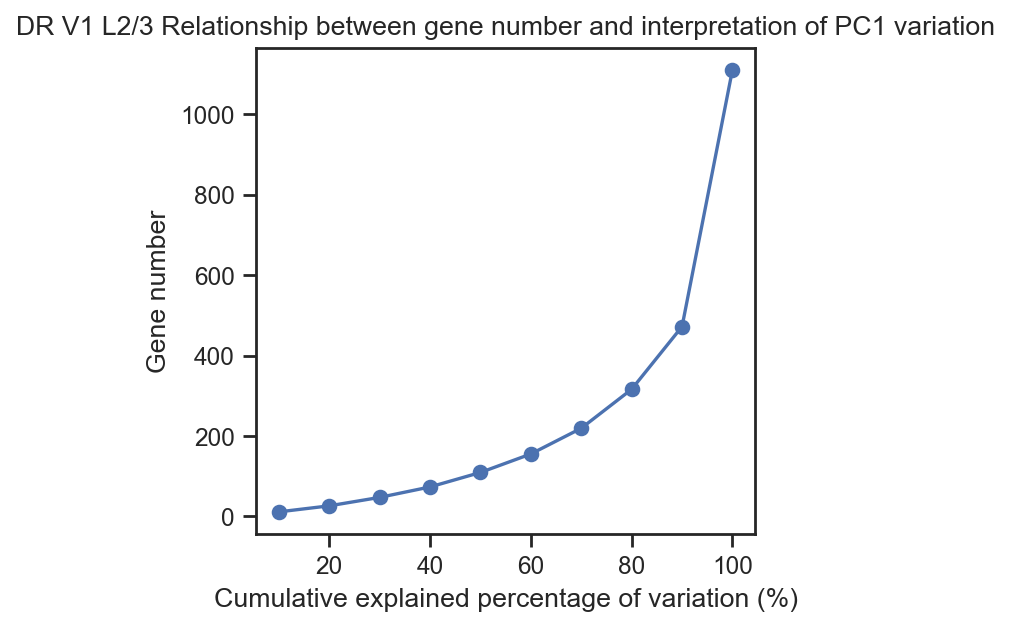

In [21]:
gene_contributions_abs_dr = gene_contributions_dr.sort_values(by='Lasso Coefficient abs', ascending=False)
print(gene_contributions_abs_dr.head())

gene_names_dr = np.array(gene_contributions_dr['Gene']) 

sorted_contribution_dr = np.sort(lasso_coefficients_abs_dr)[::-1]

cumulative_contribution_dr = np.cumsum(sorted_contribution_dr)

total_contribution_dr = cumulative_contribution_dr[-1]

sorted_idx_dr = np.argsort(np.abs(lasso_coefficients_dr))[::-1]

num_genes_90pct_dr = np.argmax(cumulative_contribution_dr >= 0.9 * total_contribution_dr) + 1
genes_90pct_idx_dr = sorted_idx_nr[:num_genes_90pct_dr]

genes_90pct_dr = gene_names_nr[genes_90pct_idx_dr]

percentages = np.arange(0.1, 1.1, 0.1)
gene_counts_dr = [np.argmax(cumulative_contribution_dr >= p * total_contribution_dr) + 1 for p in percentages]

print("解释不同变异百分比所需的基因数:", gene_counts_dr)

plt.plot(percentages * 100, gene_counts_dr, marker='o')
plt.xlabel('Cumulative explained percentage of variation (%)')
plt.ylabel('Gene number')
plt.title('DR V1 L2/3 Relationship between gene number and interpretation of PC1 variation')
#plt.grid(True)
plt.show()

In [22]:
num_genes = np.argmax(cumulative_contribution_dr >= 1 * total_contribution_dr) + 1
genes_idx_dr = sorted_idx_dr[:num_genes]
genes_dr = gene_names_dr[genes_idx_dr]

In [23]:
genes_dr.shape

(1111,)

In [25]:
genes_dr[1]

'Robo1'

In [29]:
dr_merge

,Gene,rank,Lasso Coefficient,Lasso Coefficient abs,PC_gene
0,0610009B22Rik,2180,0.000000,0.000000,No
1,0610009L18Rik,2505,0.000000,0.000000,No
2,0610012G03Rik,1640,-0.000000,0.000000,No
3,0610030E20Rik,2788,-0.000000,0.000000,No
4,0610040F04Rik,2257,0.000000,0.000000,No
...,...,...,...,...,...
3192,mt-Co3,1454,0.002823,0.002823,Yes
3193,mt-Cytb,2543,0.000000,0.000000,No
3194,mt-Nd1,1541,0.000000,0.000000,No
3195,mt-Nd2,849,0.000825,0.000825,Yes


In [28]:
PC_gene = []
for i in range(dr_merge.shape[0]):
    if dr_merge['Gene'][i] in set(genes_dr):
        PC_gene.append('Yes')
    else:
        PC_gene.append('No')
dr_merge['PC_gene'] = PC_gene


In [30]:
dr_merge['PC_gene'].value_counts()

PC_gene
No     2086
Yes    1111
Name: count, dtype: int64

In [31]:
nr_pca_gene = pd.DataFrame()
nr_pca_gene['Gene'] = genes_sel_nr[pc1_idx_nr]
nr_pca_gene['rank'] = range(nr_pca_gene.shape[0])
nr_merge = pd.merge(nr_pca_gene, gene_contributions_abs_nr, on='Gene', how='outer')
PC_gene = []
for i in range(nr_merge.shape[0]):
    if nr_merge['Gene'][i] in set(genes_nr):
        PC_gene.append('Yes')
    else:
        PC_gene.append('No')
nr_merge['PC_gene'] = PC_gene

In [32]:
nr_merge['PC_gene'].value_counts()

PC_gene
No     1700
Yes     884
Name: count, dtype: int64

In [33]:
nr_merge

,Gene,rank,Lasso Coefficient,Lasso Coefficient abs,PC_gene
0,1110002J07Rik,2477,0.000000,0.000000,No
1,1110019D14Rik,964,-0.000227,0.000227,Yes
2,1110046J04Rik,1156,0.000000,0.000000,No
3,1190005I06Rik,2181,0.000000,0.000000,No
4,1500009L16Rik,2246,-0.000000,0.000000,No
...,...,...,...,...,...
2579,mt-Nd1,1713,-0.000000,0.000000,No
2580,mt-Nd2,634,0.001774,0.001774,Yes
2581,mt-Nd3,1596,0.000000,0.000000,No
2582,mt-Nd4,696,0.001169,0.001169,Yes


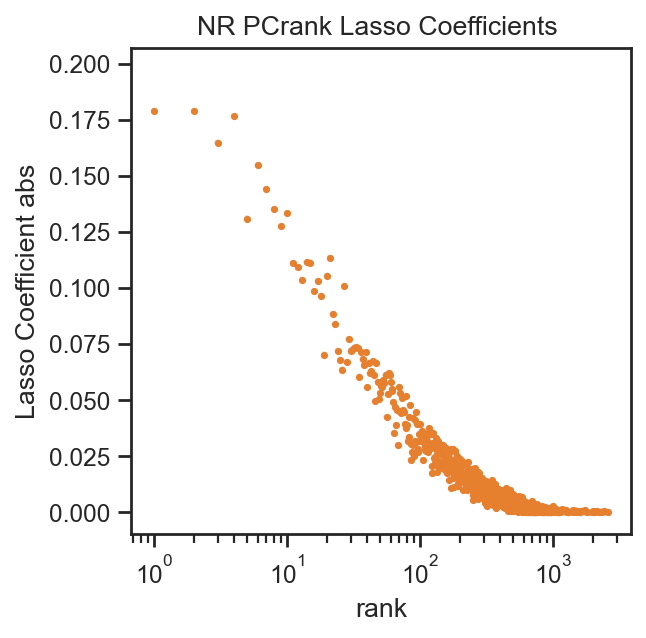

In [41]:
PC_gene = nr_merge[nr_merge['PC_gene'] == 'Yes']
# 创建绘图区域和子图
fig, ax = plt.subplots(figsize=(4, 4))
# 绘制原始散点图
sns.scatterplot(data=nr_merge, x='rank', y='Lasso Coefficient abs',s=8, color='lightgray' ,edgecolor='none',ax=ax)
ax.scatter(PC_gene['rank'], PC_gene['Lasso Coefficient abs'], color='#e6802f', s=5, label='PC gene')
ax.set_xscale('log')
plt.title('NR PCrank Lasso Coefficients ')
plt.savefig('NR_PCrank_Lasso_Coefficients_1.pdf')

Text(0.5, 1.0, 'NR PCrank Lasso Coefficients ')

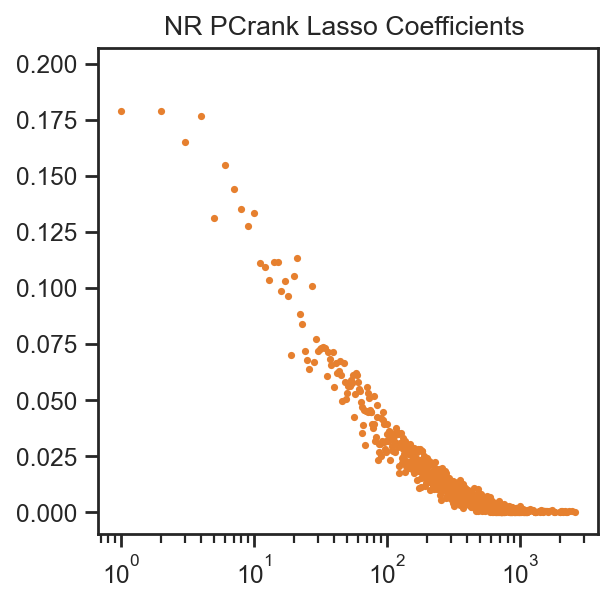

In [42]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(PC_gene['rank'], PC_gene['Lasso Coefficient abs'], color='#e6802f', s=5, label='PC gene')
ax.set_xscale('log')
plt.title('NR PCrank Lasso Coefficients ')


In [45]:
PC_gene

,Gene,rank,Lasso Coefficient,Lasso Coefficient abs,PC_gene
1,1110019D14Rik,964,-0.000227,0.000227,Yes
6,1500035N22Rik,522,-0.002801,0.002801,Yes
8,1700007F19Rik,508,0.002651,0.002651,Yes
11,1700016P03Rik,236,0.018295,0.018295,Yes
15,1700024B18Rik,1011,-0.000152,0.000152,Yes
...,...,...,...,...,...
2575,mt-Co1,673,0.003631,0.003631,Yes
2576,mt-Co2,700,0.002512,0.002512,Yes
2577,mt-Co3,468,0.007819,0.007819,Yes
2580,mt-Nd2,634,0.001774,0.001774,Yes


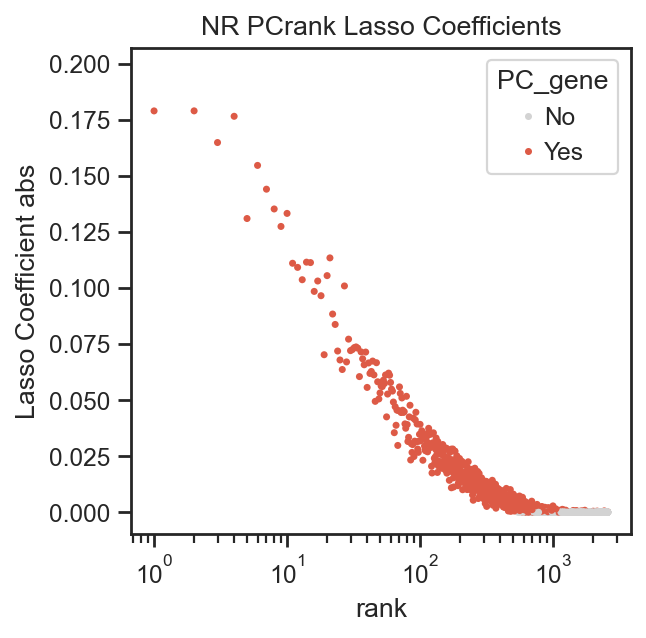

In [64]:
custom_palette = {'Yes': '#DD5A46', 'No': 'lightgray'}

fig, ax = plt.subplots(figsize=(4, 4))

# 使用scatterplot方法，指定自定义颜色调色板
sns.scatterplot(data=nr_merge, x='rank', y='Lasso Coefficient abs', s=10, hue='PC_gene',
                palette=custom_palette, edgecolor='none', ax=ax)

# 设置对数坐标轴
ax.set_xscale('log')

# 设置图标题
plt.title('NR PCrank Lasso Coefficients')

# 显示图形
plt.savefig('NR_PCrank_Lasso_Coefficients_1.pdf')

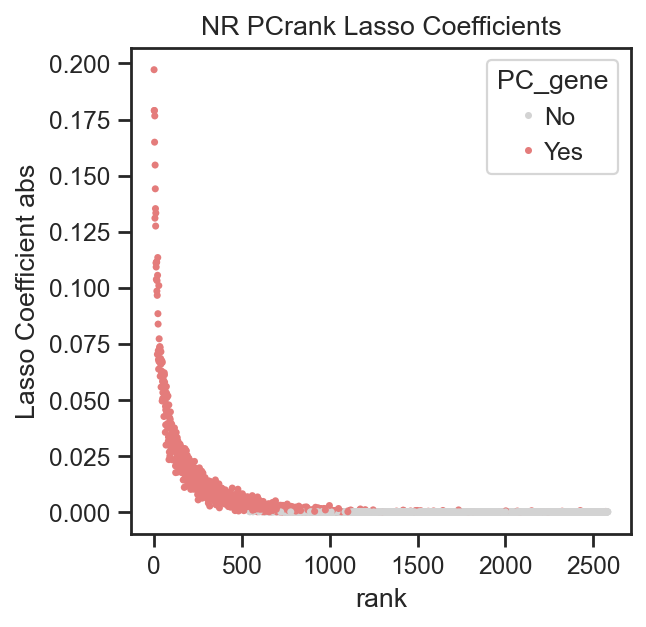

In [59]:
fig, ax = plt.subplots(figsize=(4, 4))

# 使用scatterplot方法，指定自定义颜色调色板
sns.scatterplot(data=nr_merge, x='rank', y='Lasso Coefficient abs', s=10, hue='PC_gene',
                palette=custom_palette, edgecolor='none', ax=ax)

# 设置对数坐标轴
#ax.set_xscale('log')

# 设置图标题
plt.title('NR PCrank Lasso Coefficients')

# 显示图形
plt.show()

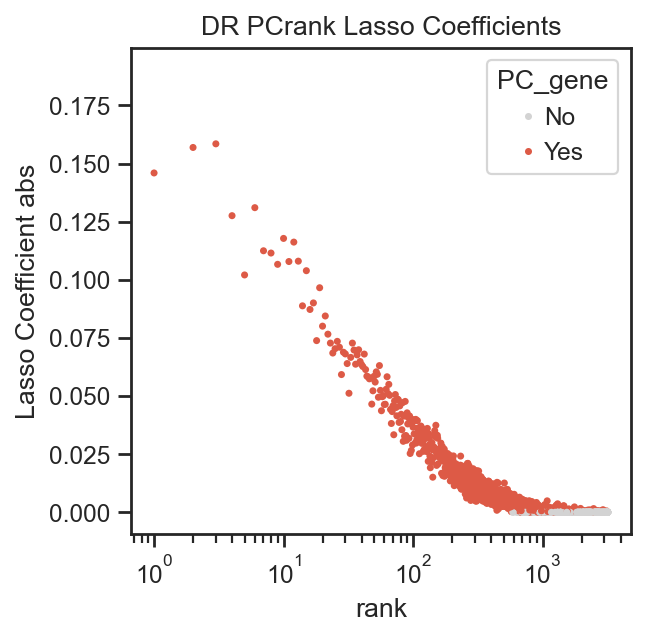

In [65]:
fig, ax = plt.subplots(figsize=(4, 4))

# 使用scatterplot方法，指定自定义颜色调色板
sns.scatterplot(data=dr_merge, x='rank', y='Lasso Coefficient abs', s=10, hue='PC_gene',
                palette=custom_palette, edgecolor='none', ax=ax)

# 设置对数坐标轴
ax.set_xscale('log')

# 设置图标题
plt.title('DR PCrank Lasso Coefficients')

# 显示图形
plt.savefig('DR_PCrank_Lasso_Coefficients_1.pdf')

In [66]:
nr

AnnData object with n_obs × n_vars = 3376 × 22105
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Class', 'preclass', 'cluster', 'Subclass', 'Sample', 'Type', 'Subtype', 'Cell_annotation'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Class_colors', 'Sample_colors', 'Subclass_colors', 'Subtype_colors', 'Type_colors', 'cluster_colors', 'hvg', 'leiden_res_0.80', 'leiden_res_0.80_colors', 'leiden_res_1.00', 'leiden_res_1.00_colors', 'leiden_res_1.20', 'leiden_res_1.20_colors', 'neighbors', 'pca', 'preclass_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
nr

AnnData object with n_obs × n_vars = 3376 × 22105
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Class', 'preclass', 'cluster', 'Subclass', 'Sample', 'Type', 'Subtype', 'Cell_annotation'
    var: 'gene_ids', 'feature_types', 'n_cells-V1_N1', 'highly_variable-V1_N1', 'means-V1_N1', 'dispersions-V1_N1', 'dispersions_norm-V1_N1', 'n_cells-V1_N2', 'highly_variable-V1_N2', 'means-V1_N2', 'dispersions-V1_N2', 'dispersions_norm-V1_N2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Class_colors', 'Sample_colors', 'Subclass_colors', 'Subtype_colors', 'Type_colors', 'cluster_colors', 'hvg', 'leiden_res_0.80', 'leiden_res_0.80_colors', 'leiden_res_1.00', 'leiden_res_1.00_colors', 'leiden_res_1.20', 'leiden_res_1.20_colors', 'neighbors', 'pca', 'preclass_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

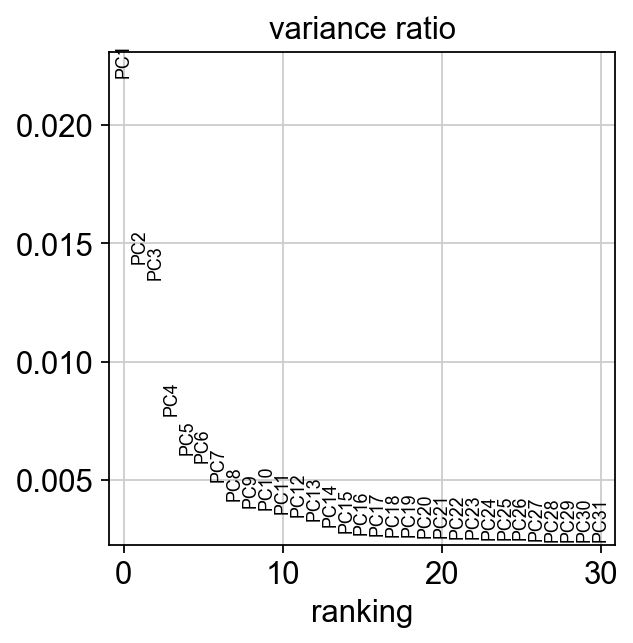

In [6]:
sc.pl.pca_variance_ratio(nr, n_pcs=30,log=False)

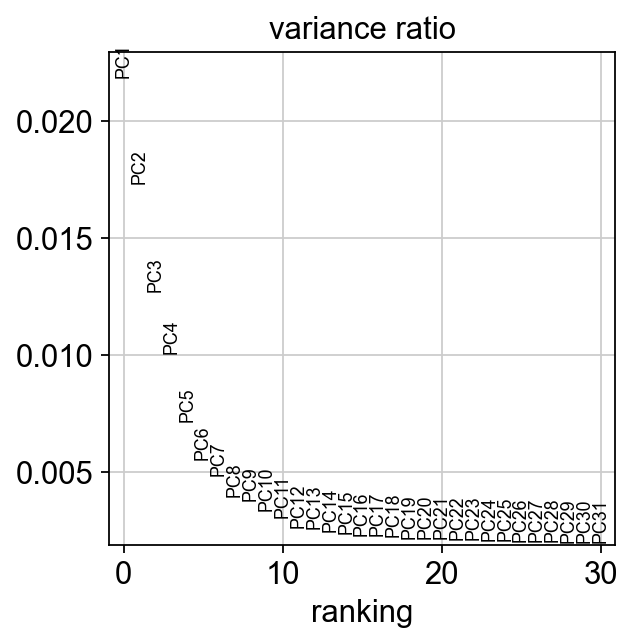

In [7]:
sc.pl.pca_variance_ratio(dr, n_pcs=30,log=False)

PC1 解释的方差比例: 0.0220


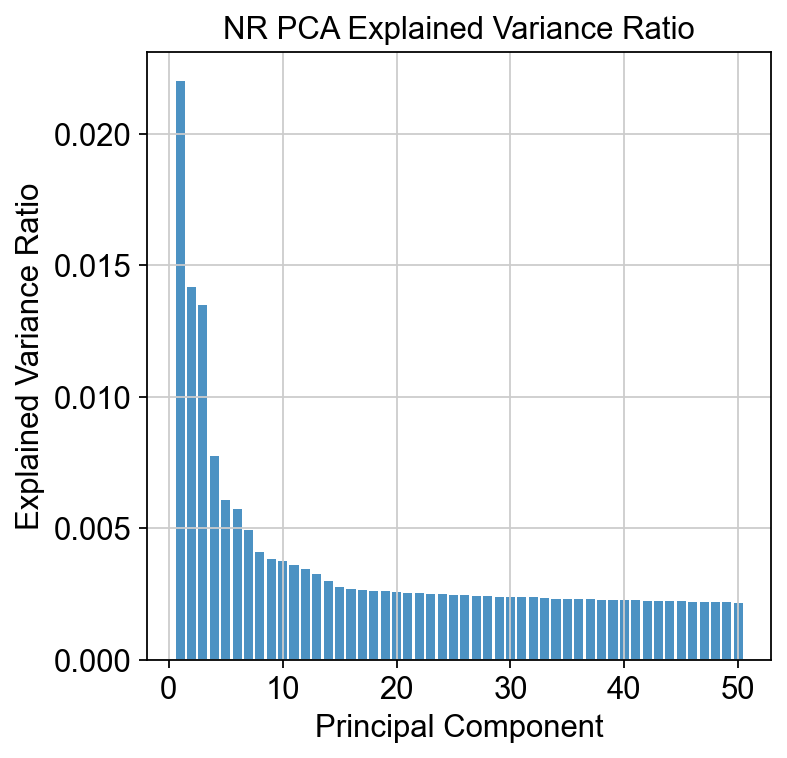

In [3]:
# 获取 PCA 的方差解释比例
variance_ratio = nr.uns['pca']['variance_ratio']

# 第一个主成分（PC1）解释的方差比例
pc1_variance = variance_ratio[0]
print(f"PC1 解释的方差比例: {pc1_variance:.4f}")
# 绘制 PCA 的方差解释比例图
plt.figure(figsize=(5, 5))
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('NR PCA Explained Variance Ratio')
plt.savefig('NR_PC1_Explained_Variance.pdf')

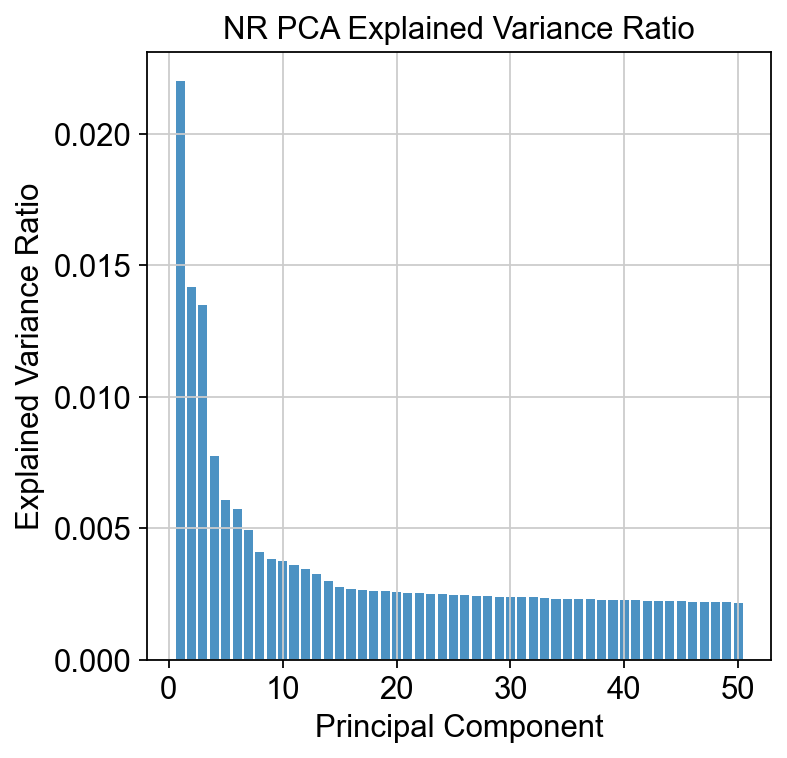

In [11]:
# 绘制 PCA 的方差解释比例图
plt.figure(figsize=(5, 5))
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('NR PCA Explained Variance Ratio')
plt.show()

DR PC1 解释的方差比例: 0.0219


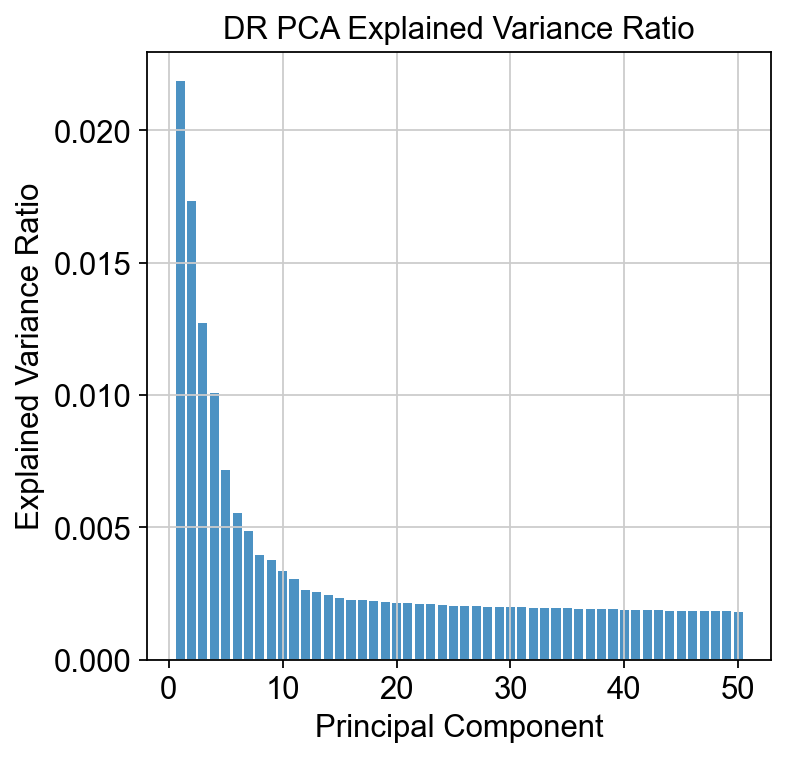

In [4]:
# 获取 PCA 的方差解释比例
variance_ratio = dr.uns['pca']['variance_ratio']

# 第一个主成分（PC1）解释的方差比例
pc1_variance = variance_ratio[0]
print(f"DR PC1 解释的方差比例: {pc1_variance:.4f}")
# 绘制 PCA 的方差解释比例图
plt.figure(figsize=(5, 5))
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('DR PCA Explained Variance Ratio')
plt.savefig('DR_PC1_Explained_Variance.pdf')